In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from keras.datasets import cifar10
from keras.utils import to_categorical
 
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from sklearn.cluster import KMeans
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.regularizers import l2

In [26]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

# EDA

In [100]:
print('Training data shape: ', trainX.shape)
print('Test data shape: ', testX.shape)
print('Number of classes: ', len(np.unique(trainY)))

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Number of classes:  10


In [101]:
# Explore the data shapes
print("Training labels shape:", trainY.shape)
print("Test labels shape:", testY.shape)

Training labels shape: (50000, 1)
Test labels shape: (10000, 1)


In [102]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [103]:
unique_train, counts_train = np.unique(trainY, return_counts=True)
print("\nTraining class distribution:")
print(dict(zip(unique_train, counts_train)))


Training class distribution:
{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [104]:
class_distribution = dict(zip(unique_test, counts_test))
class_df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])
class_df['Class'] = class_df['Class'].map({k: label_names[k] for k in class_distribution.keys()})

In [105]:
class_df.head(10)

,Class,Count
0,airplane,1000
1,automobile,1000
2,bird,1000
3,cat,1000
4,deer,1000
5,dog,1000
6,frog,1000
7,horse,1000
8,ship,1000
9,truck,1000


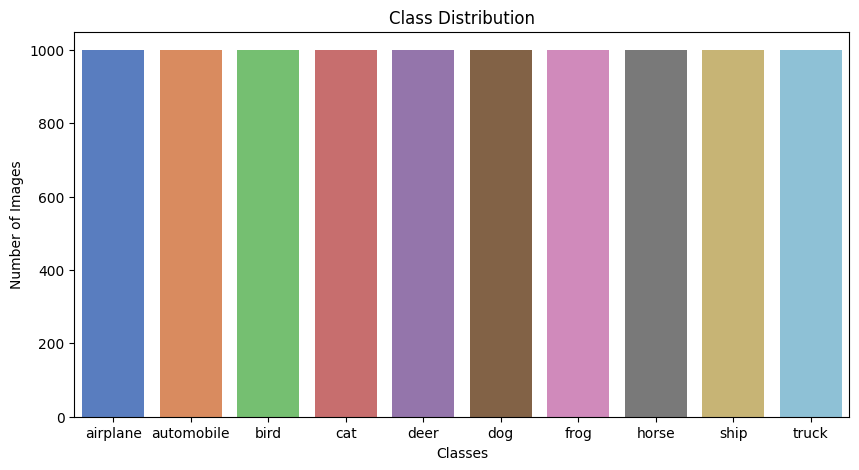

In [106]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=class_df, palette='muted')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [107]:
unique_test, counts_test = np.unique(testY, return_counts=True)
print("\nTest class distribution:")
print(dict(zip(unique_test, counts_test)))


Test class distribution:
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [108]:
class_distribution = dict(zip(unique_test, counts_test))
class_df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])
class_df['Class'] = class_df['Class'].map({k: label_names[k] for k in class_distribution.keys()})

In [109]:
class_df.head(10)

,Class,Count
0,airplane,1000
1,automobile,1000
2,bird,1000
3,cat,1000
4,deer,1000
5,dog,1000
6,frog,1000
7,horse,1000
8,ship,1000
9,truck,1000


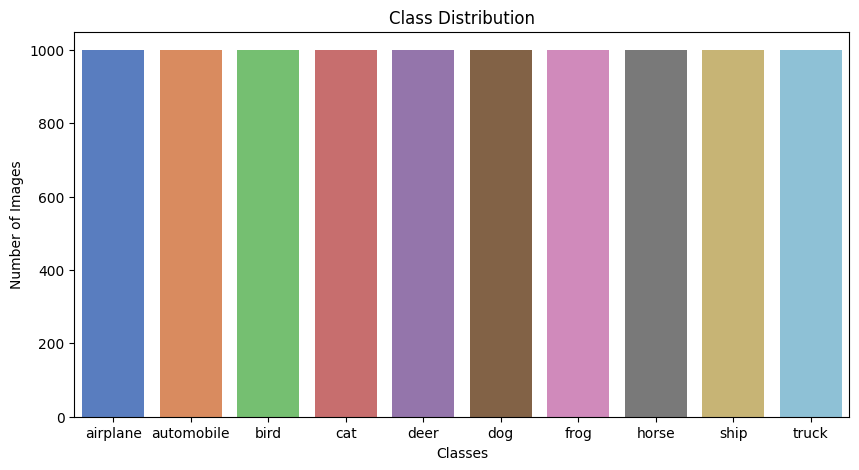

In [110]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=class_df, palette='muted')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [78]:
# basic statistics
print("\nTraining data statistics:")
print("Min pixel value:", np.min(trainX))
print("Max pixel value:", np.max(trainX))
print("Mean pixel value:", np.mean(trainX))
print("Standard deviation of pixel values:", np.std(trainX))


print("\nTesting data statistics:")
print("Min pixel value:", np.min(testX))
print("Max pixel value:", np.max(testX))
print("Mean pixel value:", np.mean(testX))
print("Standard deviation of pixel values:", np.std(testX))


Training data statistics:
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 120.70756512369792
Standard deviation of pixel values: 64.1500758911213

Testing data statistics:
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 121.52915475260417
Standard deviation of pixel values: 64.06097012299574


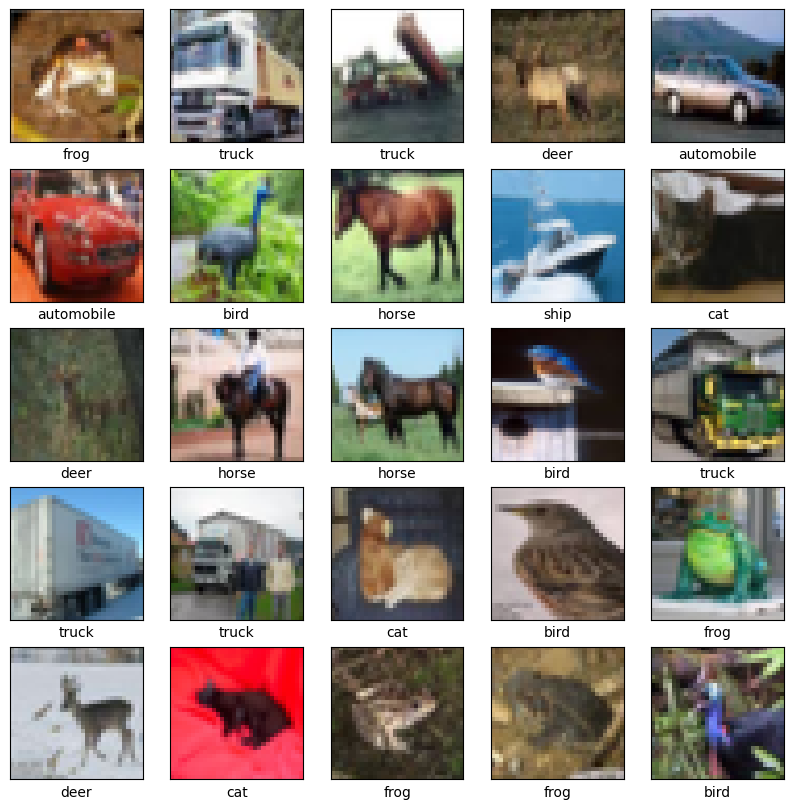

In [84]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i])
    plt.xlabel(label_names[trainY[i][0]])
plt.show()

# Normalize the images

In [30]:
print('Train X value:', trainX[0])
print('Test X value:', testX[0])

Train X value: [[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
Test X value: [[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 

In [31]:
X_train = trainX / 255.0
X_test = testX / 255.0

In [32]:
print('Train X value after normalization:', X_train[0])
print('Test X value after normalization:', X_test[0])

Train X value after normalization: [[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  

# One hot encoding categorical variable

In [33]:
y_train = to_categorical(trainY)
y_test = to_categorical(testY)

In [34]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# K-Nearest Neighbors (KNN)

In [35]:
train_images_flat = X_train.reshape(X_train.shape[0], -1)
test_images_flat = X_test.reshape(X_test.shape[0], -1)

In [36]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_images_flat, trainY)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [37]:
train_predictions= knn_model.predict(train_images_flat)
test_predictions = knn_model.predict(test_images_flat)
accuracy_train = accuracy_score(trainY, train_predictions)
accuracy_test = accuracy_score(testY, test_predictions)
print("Accuray Train set: ", accuracy_train)
print("Accuracy Test Set:", accuracy_test)

Accuray Train set:  0.57904
Accuracy Test Set: 0.3303


In [38]:
model = Sequential([
# Define input layer
InputLayer(shape=(32, 32, 3)),
Conv2D(32, (3, 3), activation='relu', padding='same'),
Conv2D(32, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(64, (3, 3), activation='relu', padding='same'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dense(10, activation='softmax'),
])

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# CNN (Convolutional Neural Network)

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
initial_train_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('initial_modal.h5')

Epoch 1/20
  42/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1159 - loss: 2.2808

W0000 00:00:1713035513.200129     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3530 - loss: 1.7446

W0000 00:00:1713035522.554568     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.3531 - loss: 1.7444 - val_accuracy: 0.5885 - val_loss: 1.1600
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6361 - loss: 1.0251 - val_accuracy: 0.6781 - val_loss: 0.9176
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7237 - loss: 0.7875 - val_accuracy: 0.7222 - val_loss: 0.7892
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7815 - loss: 0.6314 - val_accuracy: 0.7452 - val_loss: 0.7372
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8161 - loss: 0.5241 - val_accuracy: 0.7615 - val_loss: 0.7286
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8476 - loss: 0.4364 - val_accuracy: 0.7575 - val_loss: 0.7542
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8720 - loss: 0.3614 - val_accuracy: 0.7715 - val_loss: 0.7437
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8957 - loss: 0.2923 - val_accura

In [41]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9727 - loss: 0.0805
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7657 - loss: 1.2306
Training Loss: 0.08098921924829483
Training Accuracy: 0.9725000262260437
Test Loss: 1.2470225095748901
Test Accuracy: 0.7656000256538391


In [42]:
initial_train_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

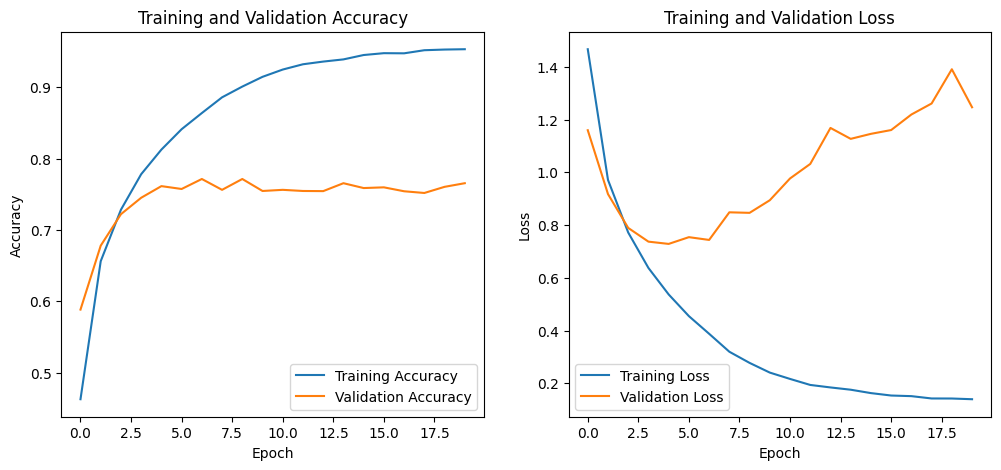

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(initial_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(initial_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(initial_train_history.history['loss'], label='Training Loss')
plt.plot(initial_train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

 99/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1713035655.369516     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


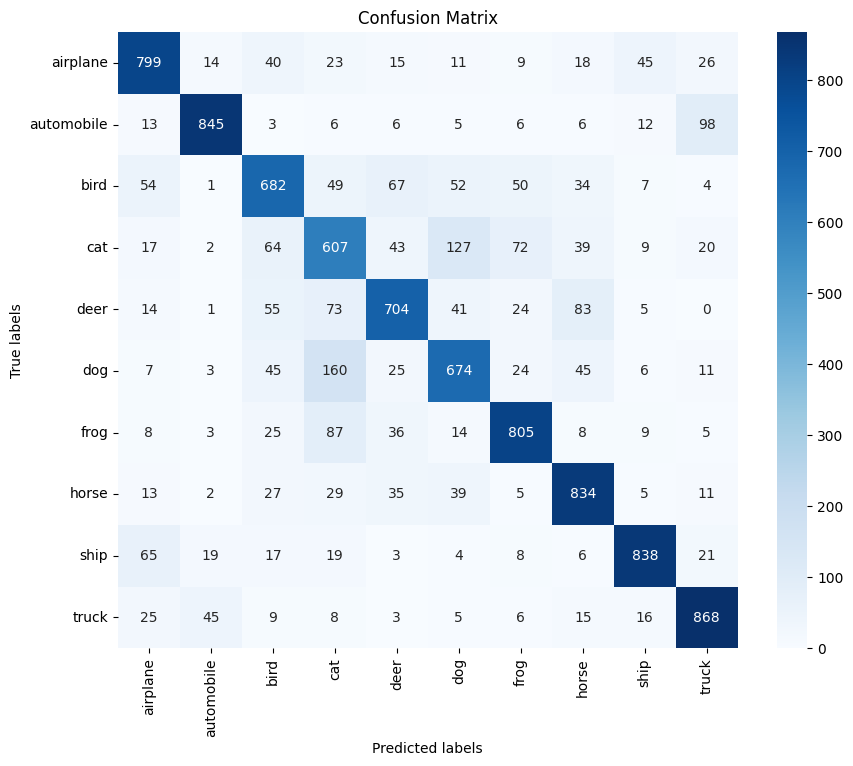

In [44]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Dropout to reduce overfitting

In [45]:
model_batch_dropout = Sequential([
InputLayer(shape=(32, 32, 3)),
Conv2D(32, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(10, activation='softmax'),
])

# compile model
model_batch_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model_batch_dropout.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
batch_dropout_train_history = model_batch_dropout.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('batch_dropout_train_modal.h5')

Epoch 1/20
  48/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0981 - loss: 2.3109

W0000 00:00:1713035662.623087     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3082 - loss: 1.8591

W0000 00:00:1713035669.952226     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3083 - loss: 1.8589 - val_accuracy: 0.4897 - val_loss: 1.4054
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5467 - loss: 1.2627 - val_accuracy: 0.6149 - val_loss: 1.0832
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6235 - loss: 1.0656 - val_accuracy: 0.6733 - val_loss: 0.9357
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6701 - loss: 0.9385 - val_accuracy: 0.7149 - val_loss: 0.8244
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7022 - loss: 0.8434 - val_accuracy: 0.7154 - val_loss: 0.8173
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7316 - loss: 0.7726 - val_accuracy: 0.7389 - val_loss: 0.7585
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7538 - loss: 0.7095 - val_accuracy: 0.7333 - val_loss: 0.7929
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7683 - loss: 0.6627 - val_accura

In [48]:
train_loss, train_accuracy = model_batch_dropout.evaluate(X_train, y_train)
test_loss, test_accuracy = model_batch_dropout.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9123 - loss: 0.2496
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7478 - loss: 0.9175
Training Loss: 0.25413209199905396
Training Accuracy: 0.9100599884986877
Test Loss: 0.9501606822013855
Test Accuracy: 0.744700014591217


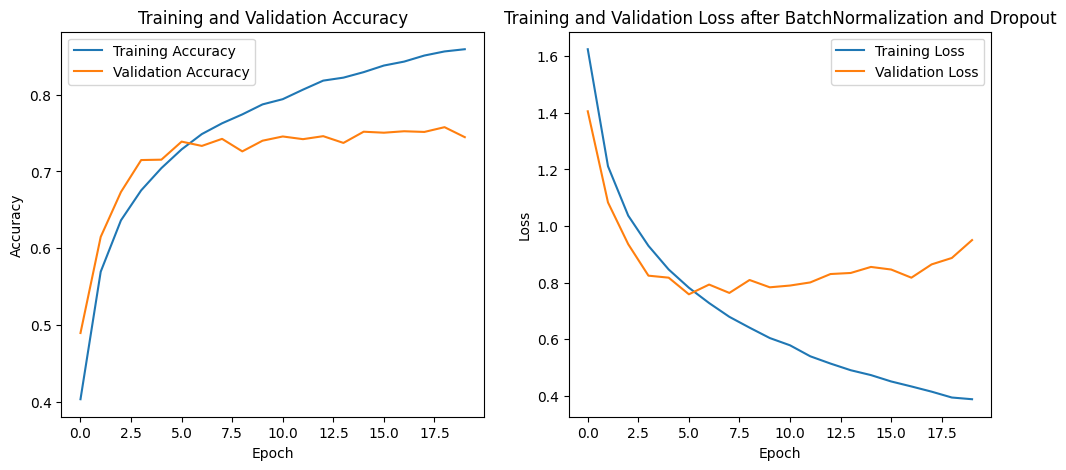

In [49]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_dropout_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(batch_dropout_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_dropout_train_history.history['loss'], label='Training Loss')
plt.plot(batch_dropout_train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after BatchNormalization and Dropout')
plt.legend()

plt.show()

106/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713035758.761340     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


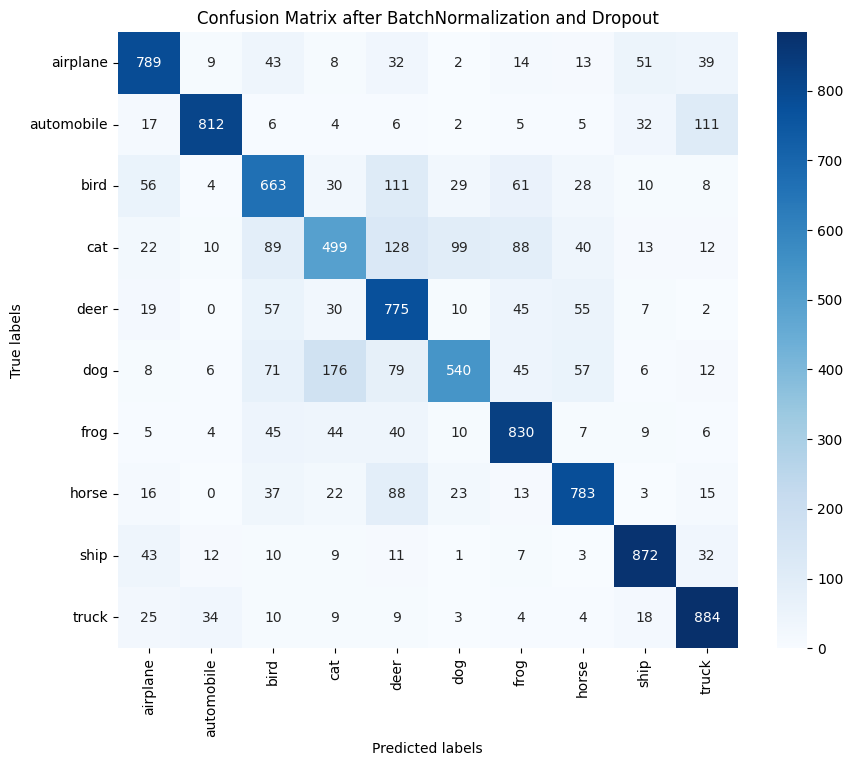

In [50]:
test_predictions = np.argmax(model_batch_dropout.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after BatchNormalization and Dropout")
plt.show()

In [51]:
cnn_with_strides = Sequential([
    InputLayer(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(250, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax'),
])

cnn_with_strides.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
cnn_with_strides.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,245,508 (4.75 MB)

 Trainable params: 1,245,508 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
cnn_with_strides_history = cnn_with_strides.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('cnn_with_strides_modal.h5')

Epoch 1/20
  42/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0989 - loss: 2.3225

W0000 00:00:1713035771.303553     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3299 - loss: 1.7955

W0000 00:00:1713035788.746617     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713035789.893877     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.3300 - loss: 1.7953 - val_accuracy: 0.5744 - val_loss: 1.1720
Epoch 2/20
  42/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5905 - loss: 1.1405

W0000 00:00:1713035790.869369     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5786 - loss: 1.1727 - val_accuracy: 0.6434 - val_loss: 1.0221
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6506 - loss: 0.9944 - val_accuracy: 0.7005 - val_loss: 0.8588
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6842 - loss: 0.9015 - val_accuracy: 0.7244 - val_loss: 0.8087
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7124 - loss: 0.8205 - val_accuracy: 0.7268 - val_loss: 0.7822
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7287 - loss: 0.7722 - val_accuracy: 0.7276 - val_loss: 0.7859
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7455 - loss: 0.7293 - val_accuracy: 0.7550 - val_loss: 0.7099
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7601 - loss: 0.6900 - val_accuracy: 0.7420 - val_loss: 0.7422
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7690 - loss: 0.6615 - val_accurac

In [54]:
train_loss, train_accuracy = cnn_with_strides.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn_with_strides.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9262 - loss: 0.2462
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7772 - loss: 0.6874
Training Loss: 0.24626529216766357
Training Accuracy: 0.9241600036621094
Test Loss: 0.6893258094787598
Test Accuracy: 0.7746999859809875


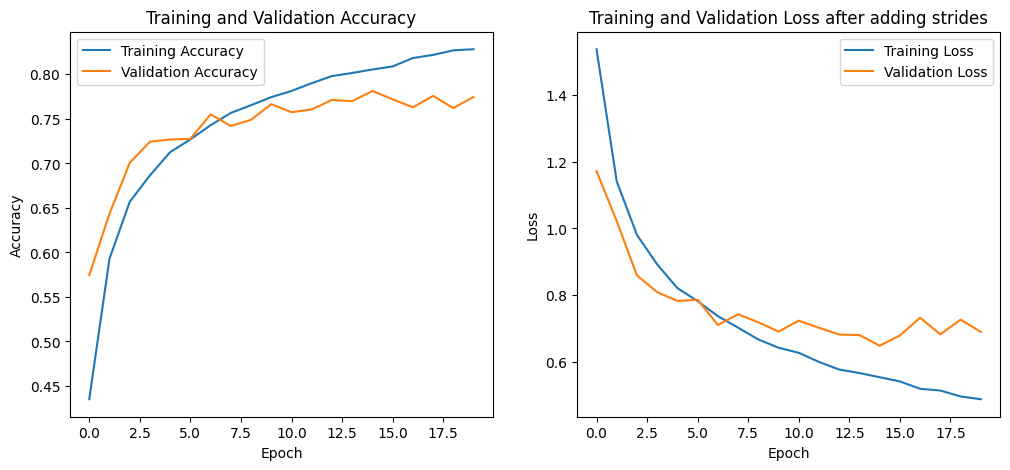

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_with_strides_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_with_strides_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after adding strides')
plt.legend()

plt.show()

104/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713035890.590246     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713035891.419868     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


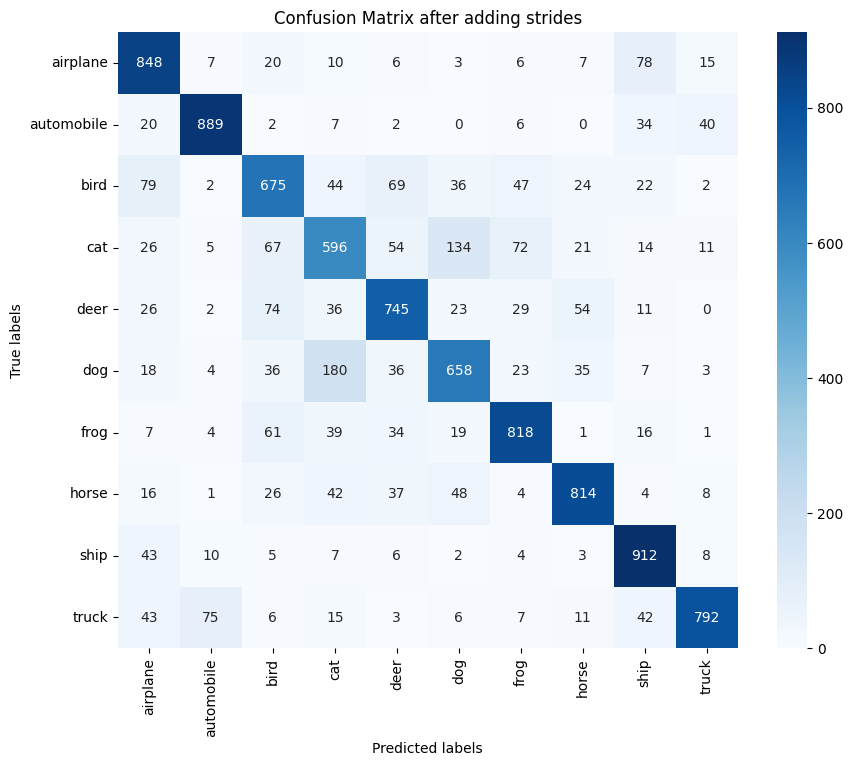

In [56]:
test_predictions = np.argmax(cnn_with_strides.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after adding strides")
plt.show()

In [57]:
cnn = Sequential([
    InputLayer(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,618 (5.20 MB)

 Trainable params: 1,362,618 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
cnn_history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('cnn_modal.h5')

Epoch 1/20
  26/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0941 - loss: 2.3181  

W0000 00:00:1713035903.425781     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2468 - loss: 1.9855

W0000 00:00:1713035916.517165     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713035917.756120     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2469 - loss: 1.9853 - val_accuracy: 0.5143 - val_loss: 1.3216
Epoch 2/20
  31/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4797 - loss: 1.4010

W0000 00:00:1713035918.930205     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5129 - loss: 1.3430 - val_accuracy: 0.6007 - val_loss: 1.1257
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5924 - loss: 1.1497 - val_accuracy: 0.6620 - val_loss: 0.9743
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6357 - loss: 1.0388 - val_accuracy: 0.6881 - val_loss: 0.8886
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6664 - loss: 0.9511 - val_accuracy: 0.7036 - val_loss: 0.8570
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6859 - loss: 0.9046 - val_accuracy: 0.7132 - val_loss: 0.8218
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7076 - loss: 0.8483 - val_accuracy: 0.7073 - val_loss: 0.8413
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7188 - loss: 0.8141 - val_accuracy: 0.7275 - val_loss: 0.7773
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7351 - loss: 0.7677 - val_accurac

In [60]:
train_loss, train_accuracy = cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8614 - loss: 0.3920
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7866 - loss: 0.6624
Training Loss: 0.39412057399749756
Training Accuracy: 0.861840009689331
Test Loss: 0.6716148853302002
Test Accuracy: 0.7825000286102295


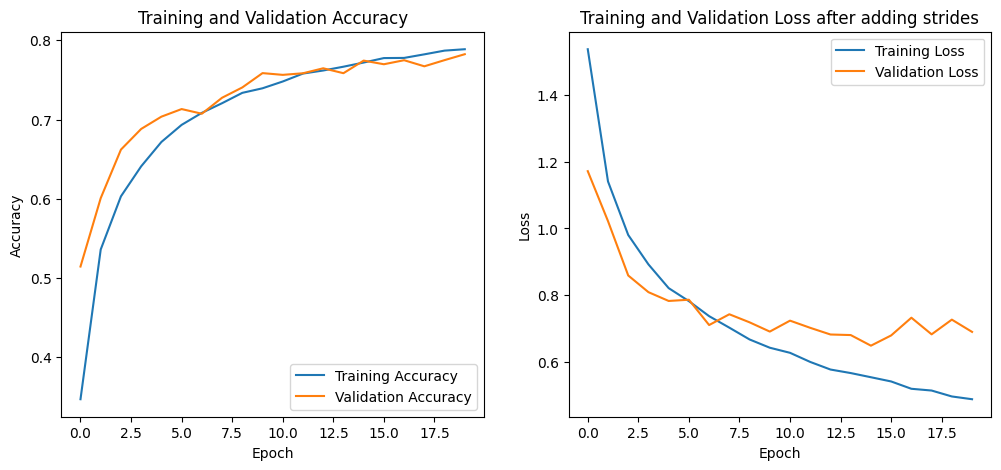

In [61]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after adding strides')
plt.legend()

plt.show()

In [62]:
cnn = Sequential([
  InputLayer(shape=(32, 32, 3)),
  Conv2D(32, (3, 3), activation='relu', padding='same'),  
  Conv2D(32, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.25), 
  Conv2D(64, (3, 3), activation='relu', padding='same'),  
  Conv2D(64, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.25),  
  Conv2D(128, (3, 3), activation='relu', padding='same'),  
  Conv2D(128, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Flatten(),
  Dense(256, activation='relu'),  
  Dropout(0.5), 
  Dense(10, activation='softmax'),
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
 18/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.0902 - loss: 2.3077  

W0000 00:00:1713036075.425883     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2639 - loss: 1.9312

W0000 00:00:1713036086.390452     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713036087.562980     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.2640 - loss: 1.9309 - val_accuracy: 0.5072 - val_loss: 1.3539
Epoch 2/100
 17/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4943 - loss: 1.3922

W0000 00:00:1713036088.535950     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5252 - loss: 1.3099 - val_accuracy: 0.6132 - val_loss: 1.0879
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6176 - loss: 1.0805 - val_accuracy: 0.6773 - val_loss: 0.9312
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6670 - loss: 0.9552 - val_accuracy: 0.7016 - val_loss: 0.8661
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7001 - loss: 0.8560 - val_accuracy: 0.7342 - val_loss: 0.7569
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7231 - loss: 0.7912 - val_accuracy: 0.7498 - val_loss: 0.7192
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7411 - loss: 0.7379 - val_accuracy: 0.7579 - val_loss: 0.6954
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7558 - loss: 0.7017 - val_accuracy: 0.7615 - val_loss: 0.6933
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7700 - loss: 0.6645 - val_accuracy: 0.7655

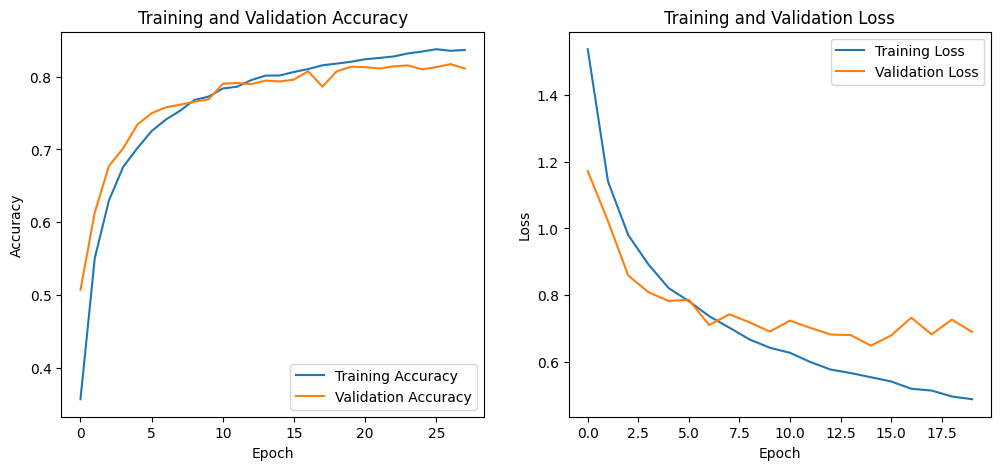

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

 94/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1713036229.016549     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713036229.936104     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


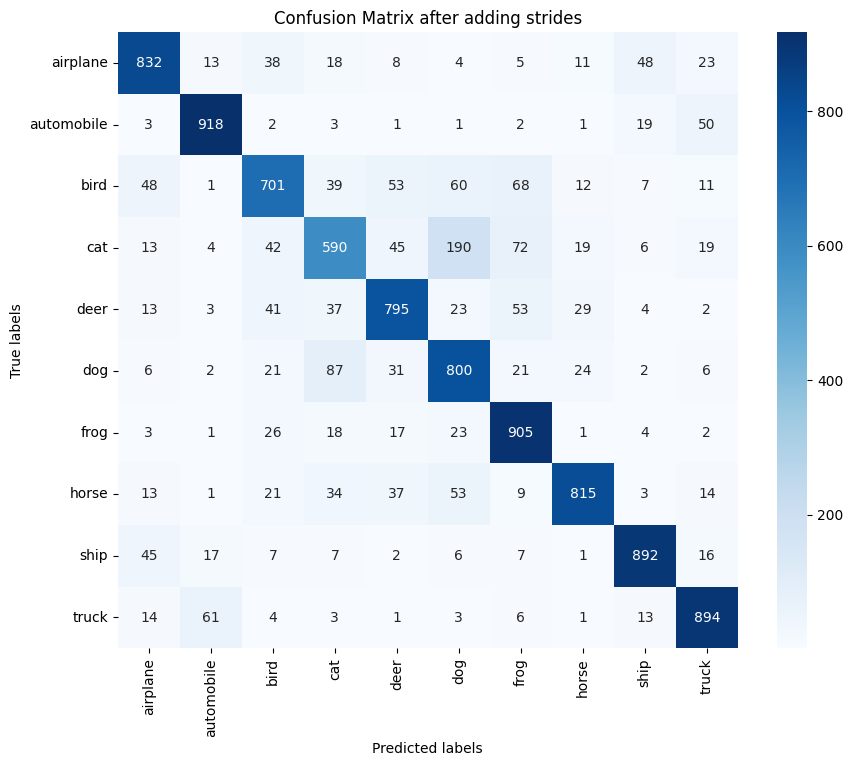

In [64]:
test_predictions = np.argmax(cnn.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after adding strides")
plt.show()

In [65]:
model.save('cnn_modal_final.h5')